# Nano Degree - Advanced Lane Finding
   
The goals / steps of this project are the following:

1. Import and initialize the packages needed in the project
2. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
3. Apply a distortion correction to raw images.
4. Use color transforms, gradients, etc., to create a thresholded binary image.
5. Apply a perspective transform to rectify binary image ("birds-eye view").
6. Detect lane pixels and fit to find the lane boundary.
7. Determine the curvature of the lane and vehicle position with respect to center.
8. Warp the detected lane boundaries back onto the original image.
9. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
10. Run pipeline in a video.


# Step 0 : Import & initialize packages, test a sample image.

The size of the image is -> (720, 1280, 3)


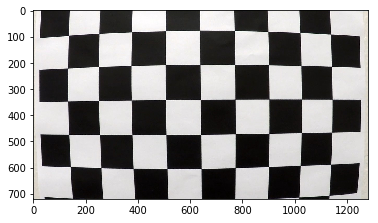

In [21]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
from matplotlib.patches import Polygon
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

img = mpimg.imread('camera_cal/calibration1.jpg')
image_shape = img.shape
img_size = (image_shape[1], image_shape[0])
print('The size of the image is ->', image_shape)
plt.imshow(img);

# Step 1: Calibrating the Camera using Calibration Matrix

Find the camera calibration matrix for the transform P(x,y,z) = Cp(x,y)
1. All the images are read from the camera_cal drive using glob
2. 9x6 corners are used for the row and column points
3. The object points and image points are calculated
4. Finaly using the object and image points the Camera Matrix, Distortion coefficients, rotaional and translational vectors are found by applying the openCV function "cameraCalibration" 

In [22]:
def calibrate_camera(images, nx=9, ny=6):
    """"
    images = paths to the images used to calibrate the camera
    nx = Number of inside corners in x
    ny = Number of inside corners in y
    """

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Apply findChessboardCorners to the individual images
    for fname in images:    
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # Camera calibration, given object points, image points, and the shape of the grayscale image
    if (len(objpoints) > 0):
        # Camera successfully calibrated.
        print("Camera successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape[:2], None, None)
    else:
        # Unable to calibrate the camera.
        print("Unable to calibrate the camera.")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return ret, mtx, dist, rvecs, tvecs
        
# Fetching the images
images = glob.glob('./camera_cal/calibration*.jpg')

ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = calibrate_camera(images)

Camera successfully calibrated.


# Step 2: Correction for Distortion

1. Applying the camera calibration matrix and distortion coefficients to test a sample image

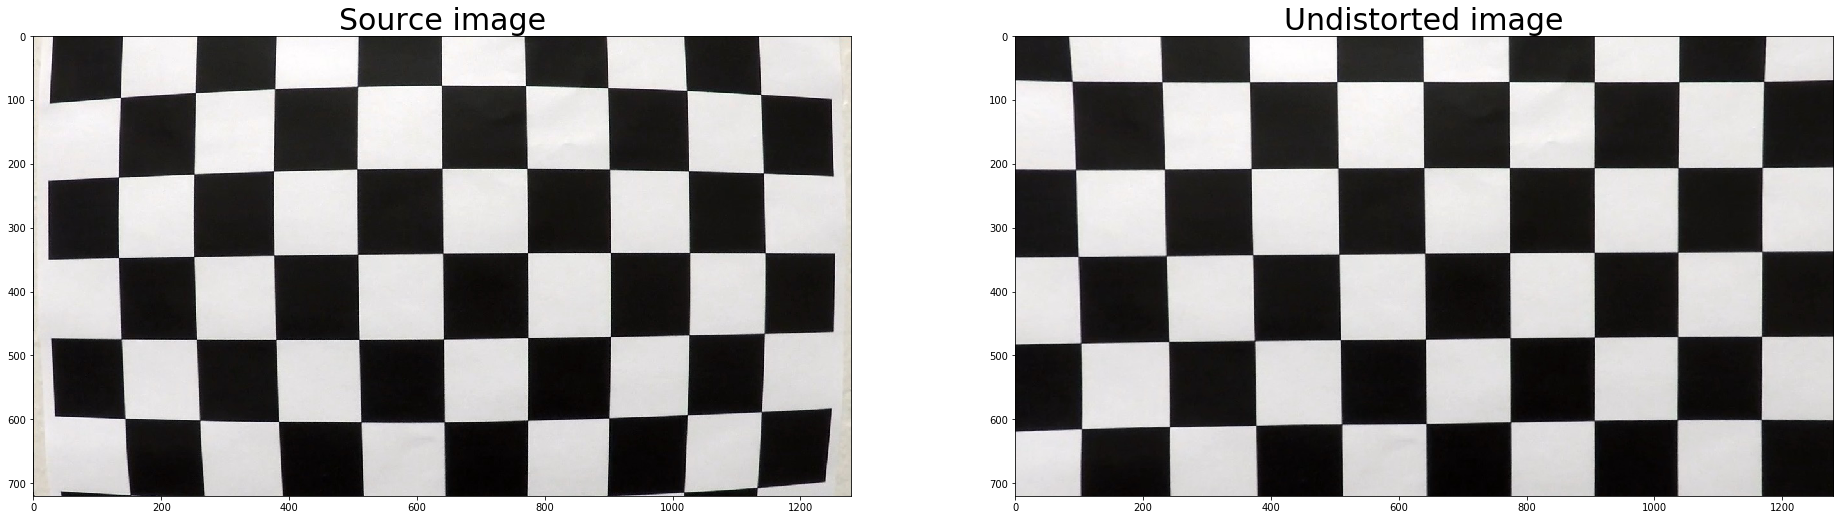

In [23]:

img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)

# Plot function to compare two images [original vs. processed]
def plt_images(orig_image, orig_title, processed_image, processed_title, cmap='gray'):
    # Visualize undirstorsion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    ax1.set_title(orig_title, fontsize=30)
    ax1.imshow(orig_image)
    ax2.set_title(processed_title, fontsize=30)
    ax2.imshow(processed_image, cmap='gray')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plt_images(img, 'Source image', undistorted, 'Undistorted image')


# Step 3: Color Transform, magnitude  & gradient to generate threshold binary image
1. Sobel transform - Directional Gradient
2. Gradient Magnitude
2. Directional threshold

## Color Thresholds:
1. R & G channel thresholds so that yellow lanes are detected well.
2. L channel threshold so that we don't take into account edges generated due to shadows.
3. S channel threshold since it does a good job of separating out white & yellow lanes.

In [24]:
# Load a test image, convert to RGB and undistort it
img = mpimg.imread('./test_images/straight_lines1.jpg')
# Undistort
undist = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
# Convert to grayscale
gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
height, width = gray.shape

# Step 3.a: Find directional gradient - Sobel Transform

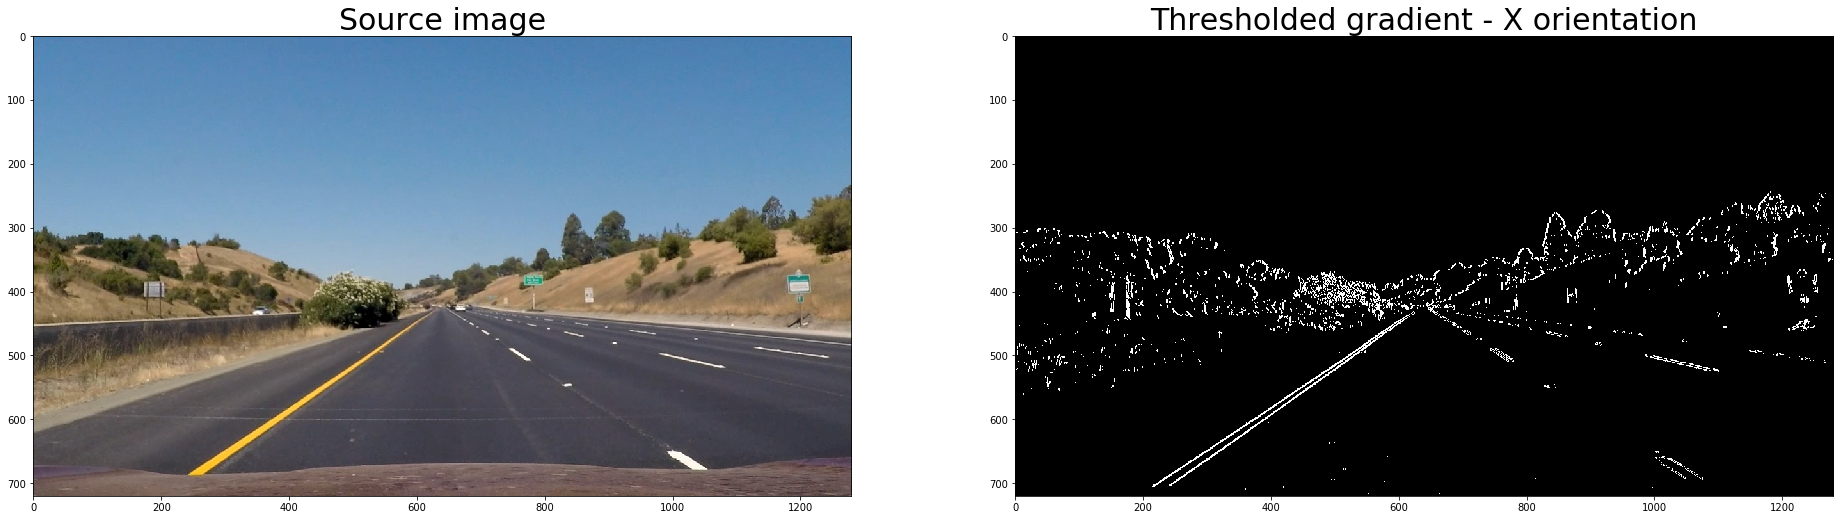

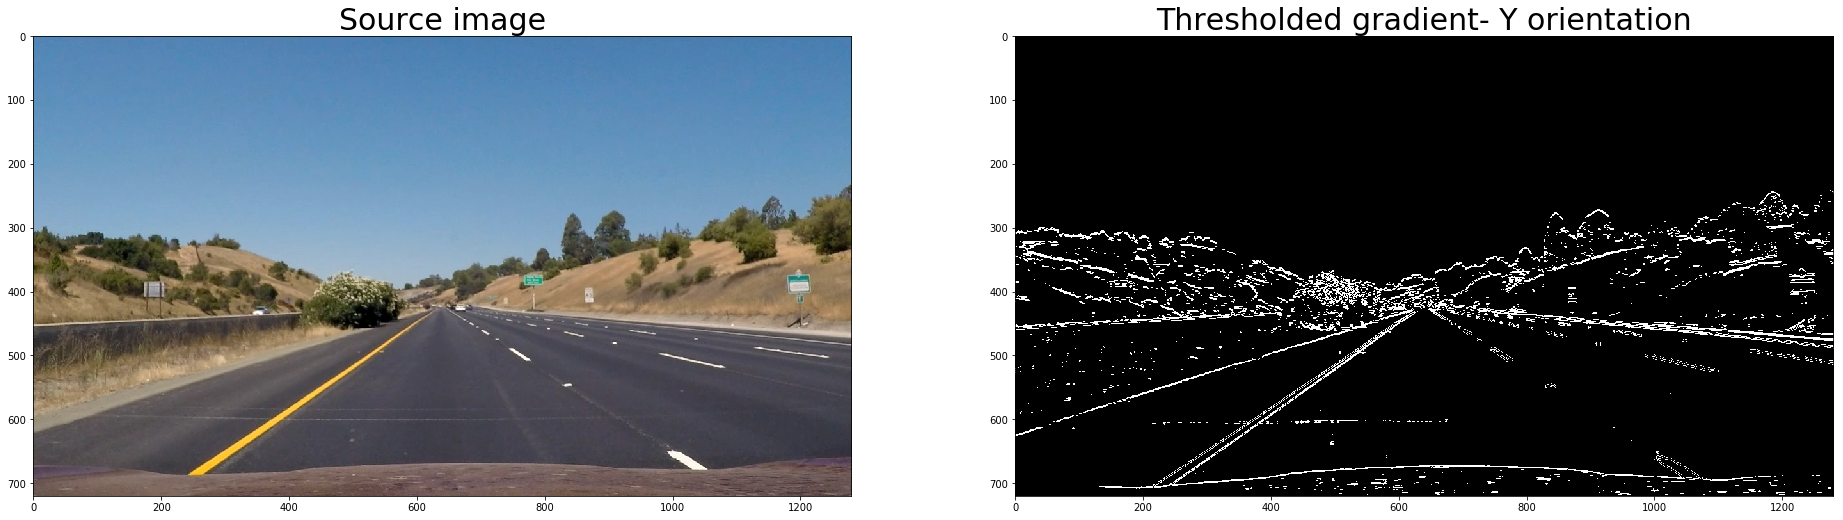

In [25]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(gray, orient='x', thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    sobel_mask = binary_output
    # Return the result
    return sobel_mask


# Run Sobel function in "x"
grad_x = abs_sobel_thresh(gray, 'x', thresh=(30, 100))

# Plot the result
plt_images(img, 'Source image', grad_x, 'Thresholded gradient - X orientation')

# Run Sobel function in "y"
grad_y = abs_sobel_thresh(gray, 'y', thresh=(30, 100))

# Plot the result
plt_images(img, 'Source image', grad_y, 'Thresholded gradient- Y orientation')

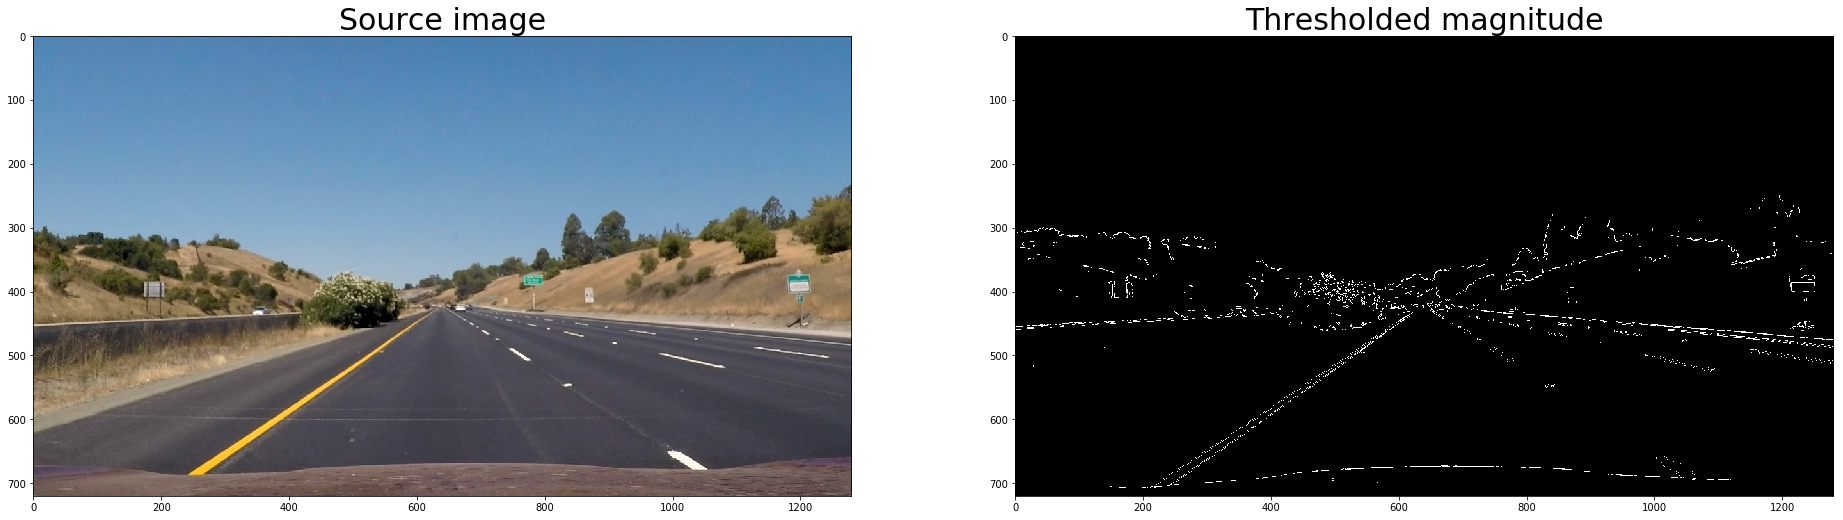

In [26]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    mag_mask = binary_output
    # Return the binary image
    return mag_mask

# Run the function
mag_binary = mag_thresh(gray, sobel_kernel=3, mag_thresh=(70, 100))

# Plot the result
plt_images(img, 'Source image', mag_binary, 'Thresholded magnitude')

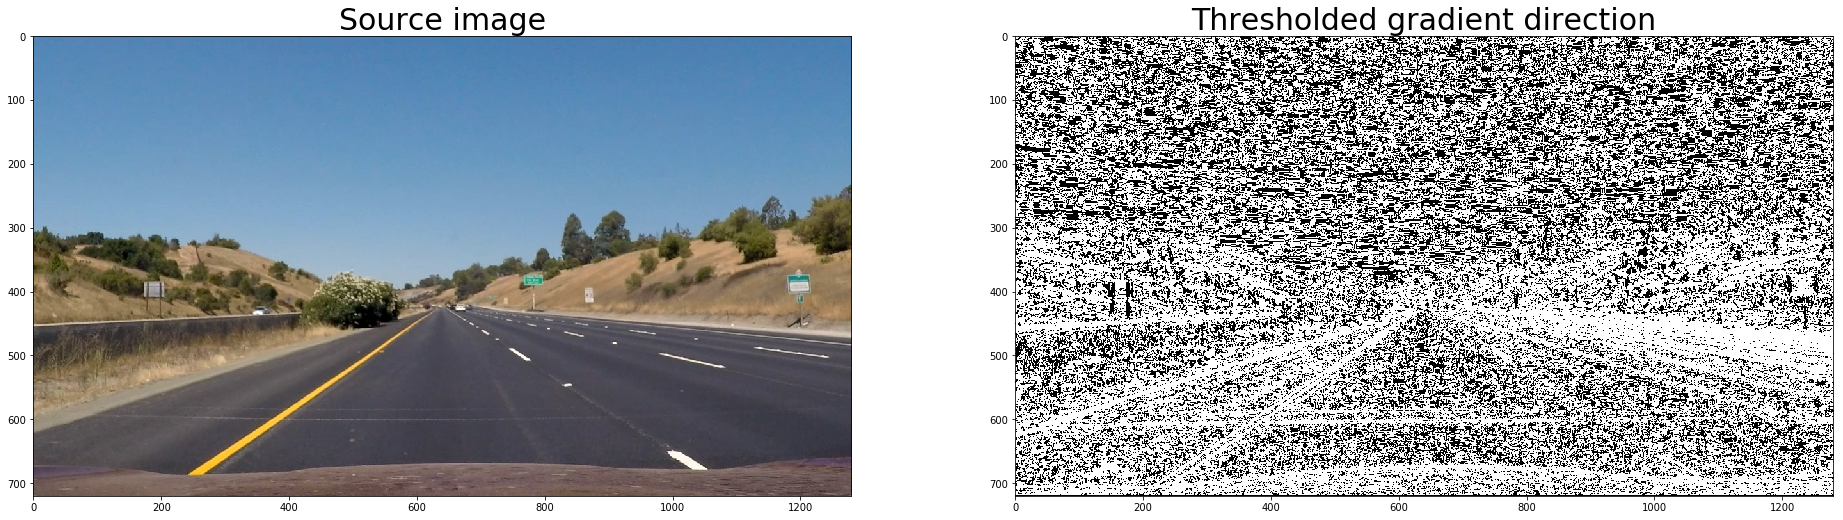

In [27]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    dir_mask = binary_output
    # Return the binary image
    return dir_mask

# Run the function
dir_binary = dir_threshold(gray, sobel_kernel=3, thresh=(np.pi/5, np.pi/2))

# Plot the result
plt_images(img, 'Source image', dir_binary, 'Thresholded gradient direction')

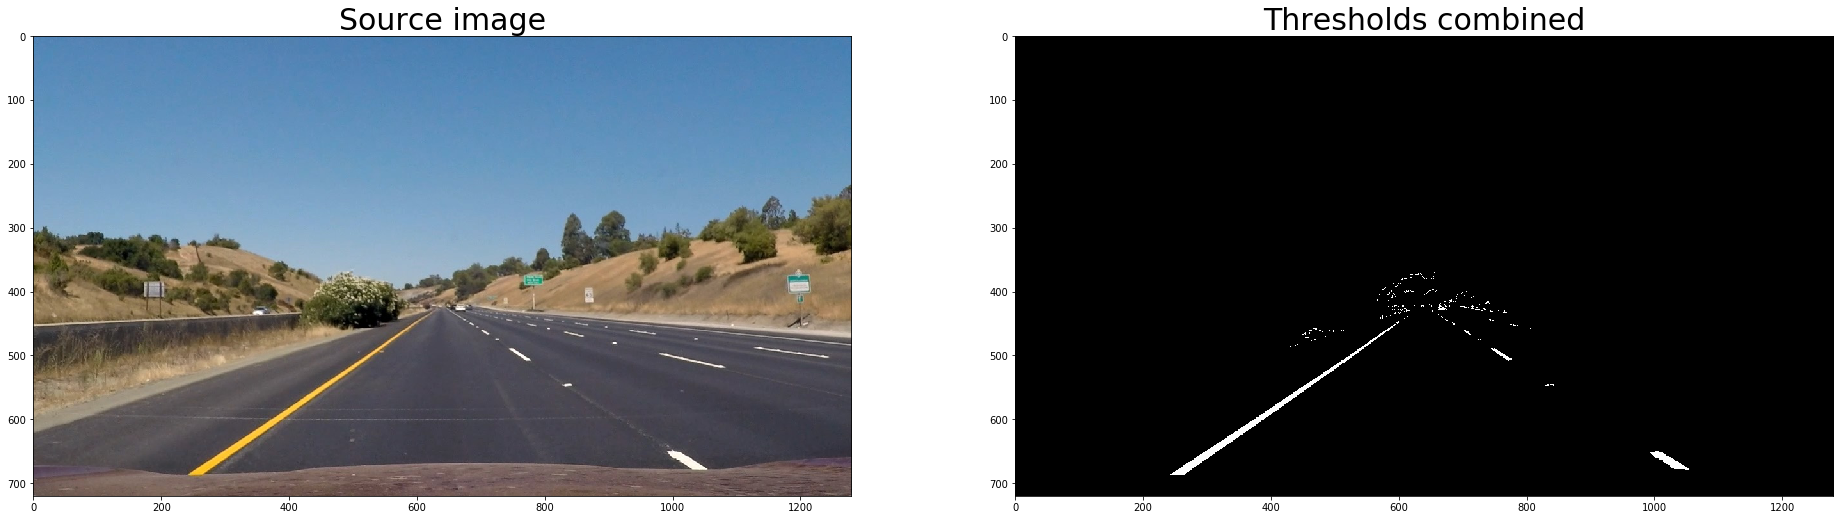

In [28]:
def combine_thresh(img, s_thresh=(100, 255), l_thresh=(120, 255)):
    
    # Undistort
    undist = cv2.undistort(img, cameraMatrix, distortionCoeffs, None, cameraMatrix)
    # Convert to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    height, width = gray.shape
    
    #combined = ((grad_x == 1)  & (grad_y == 1) & (mag_binary == 1) & (dir_binary == 1))
    grad_x = abs_sobel_thresh(gray, 'x', thresh=(10, 200))
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    combined = ((grad_x == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # Apply color threshold for better detection of yello and white lines in all environmental condition
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Select S channel because it is usually the best performant
    # for this task. R channel also performs similarly.
    s_channel = hls[:,:,2] 
    l_channel = hls[:,:,1]
    
     # S channel performs well for detecting bright yellow and white lanes
    s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    
    # We put a threshold on the L channel to avoid pixels which have shadows and as a result darker.   
    l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])
    
    # combine all the thresholds
    # A pixel should either be a yellowish or whiteish
    # And it should also have a gradient, as per our thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined)] = 1
    
    #binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)

    return thresholded

# Run the function
combined = combine_thresh(img,s_thresh=(100, 255), l_thresh=(120, 255))

# Plot the result
plt_images(img, 'Source image', combined, 'Thresholds combined')

## One function to apply all thresholding

This function takes in the image and apply all the relevant thresholding including gray scale conversion, undistortion, sobel transform, directional transform and color channel transofrms

In [29]:
def thresholding(img):

    thresholded = combine_thresh(img,s_thresh=(100, 255), l_thresh=(120, 255))
    return thresholded

# Step 4: Perspective Transform
Using manual inspection of the sample images, the vertices are extracted to perform a perspective transform. The polygon with these vertices is drawn on the image for visualization. Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.

The transform and its inverse are computed for later use. The binary image is then converted to show the birds eye view.

In [30]:
def binary(img):
    
    thresholded = thresholding(img)
    # Vertices extracted manually for performing a perspective transform
    bottom_left = [220,720]
    bottom_right = [1110, 720]
    top_left = [570, 470]
    top_right = [722, 470]

    source = np.float32([bottom_left,bottom_right,top_right,top_left])

    pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
    pts = pts.reshape((-1,1,2))
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

    # Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
    bottom_left = [320,720]
    bottom_right = [920, 720]
    top_left = [320, 1]
    top_right = [920, 1]

    dst = np.float32([bottom_left,bottom_right,top_right,top_left])
    M = cv2.getPerspectiveTransform(source, dst)
    M_inv = cv2.getPerspectiveTransform(dst, source)
    img_size = (image_shape[1], image_shape[0])

    warped = cv2.warpPerspective(thresholded, M, img_size , flags=cv2.INTER_LINEAR)
    return warped, M_inv
    


Image  0 :  test_images/test1.jpg
Image  1 :  test_images/test3.jpg
Image  2 :  test_images/straight_lines2.jpg
Image  3 :  test_images/test4.jpg
Image  4 :  test_images/straight_lines1.jpg
Image  5 :  test_images/test5.jpg
Image  6 :  test_images/test6.jpg
Image  7 :  test_images/test2.jpg


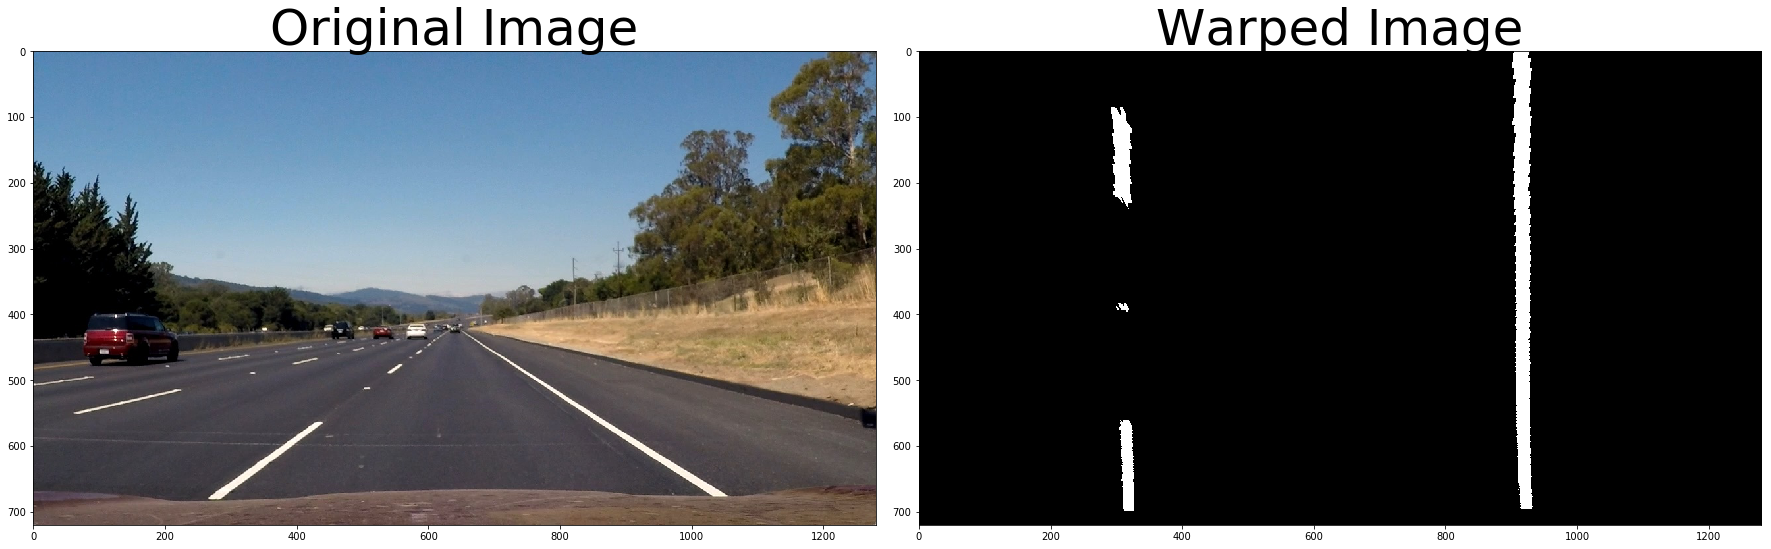

In [31]:
#Read test images names
images = glob.glob('test_images/*.jpg')

#print names
for i in range(len(images)):
    print("Image ", i, ": " ,images[i] )
    
#Randomly choosing a image
choice = np.random.choice(len(images))

#read image
img = mpimg.imread(images[choice])

# Test Binary Function
warped, M_inv = binary(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Step 5: Detect lane pixels and fit to find the lane boundary.
## Identifying the lane pixels: Part 1
Histogram
The peaks int the histogram tell us about the likely position of the lanes in the image.

Leftx Base =  312 Rightx_Base =  914


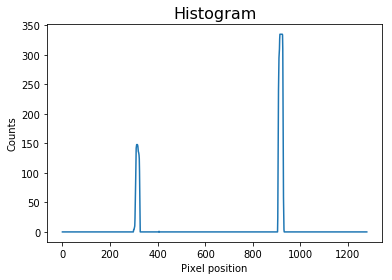

In [32]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)

# Peak in the first half indicates the likely position of the left lane
half_width = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:half_width])

# Peak in the second half indicates the likely position of the right lane
rightx_base = np.argmax(histogram[half_width:]) + half_width


print('Leftx Base = ', leftx_base,'Rightx_Base = ', rightx_base)
# Plot the results
plt.title('Histogram', fontsize=16)
plt.xlabel('Pixel position')
plt.ylabel('Counts')
plt.plot(histogram);

## Identifying the lane pixels: Part 2
## Sliding Window Search

Starting with the base likely positions of the 2 lanes, calculated from the histogram. 10 windows of width 100 pixels are used.

The x & y coordinates of non zeros pixels are found, a polynomial is fit for these coordinates and the lane lines are drawn.

In [33]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped.shape[0] - (window+1)*window_height
    win_y_high = warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

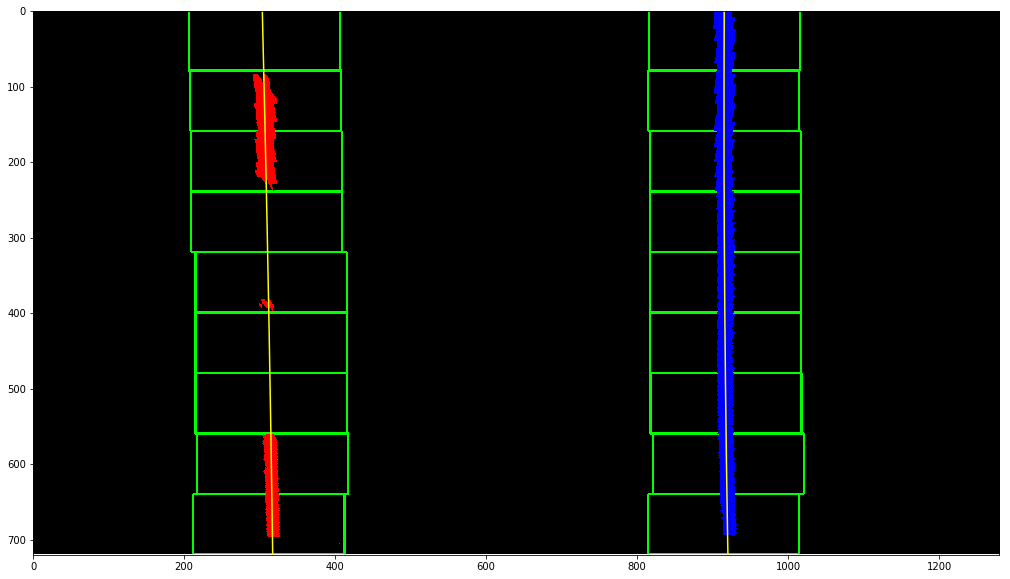

In [34]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(20,10));
plt.imshow(out_img);
plt.plot(left_fitx, ploty, color='yellow');
plt.plot(right_fitx, ploty, color='yellow');
plt.xlim(0, 1280);
plt.ylim(720, 0);

## Identifying the lane pixels: Part 3
## Searching around a previously detected line.

Since consecutive frames are likely to have lane lines in roughly similar positions, in this section we search around a margin of 50 pixels of the previously detected lane lines.

In [39]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

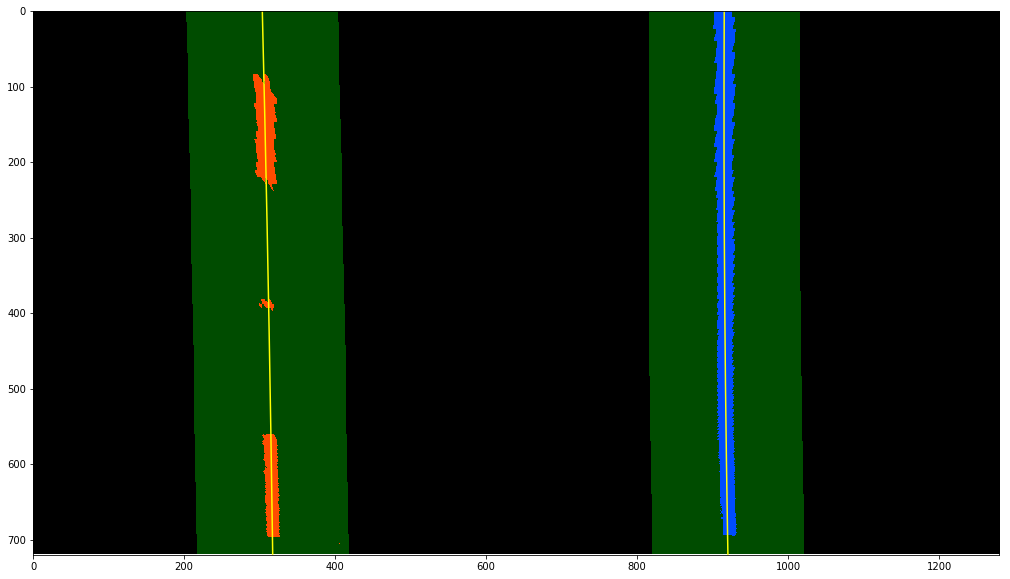

In [40]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(20,10))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0);

In [41]:
def fitlines(warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit =[]
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit =[]
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    

    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    return left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty

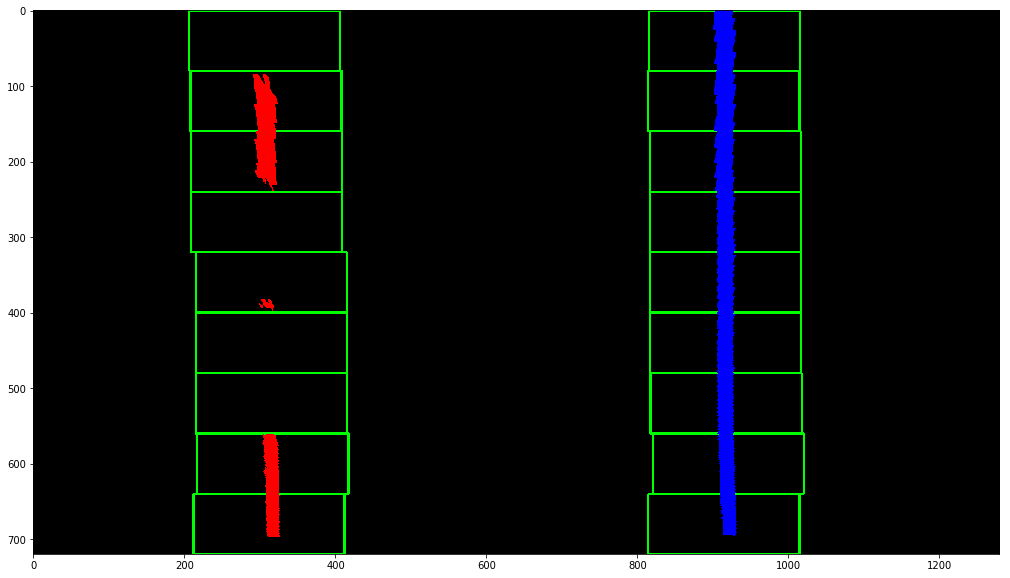

In [42]:
# Test the Fitlines Function
left_fit, right_fit, out_img, lefty, leftx, righty, rightx, ploty = fitlines(warped)

plt.figure(figsize=(20,10))
plt.imshow(out_img);


# Step 6: Determine the curvature of the lane and vehicle position with respect to center.

## Computing the radius of curvature and center offset.
The radius of curvature is computed according to the formula and method described in the classroom material. Since we perform the polynomial fit in pixels and whereas the curvature has to be calculated in real world meters, we have to use a pixel to meter transformation and recompute the fit again.

The mean of the lane pixels closest to the car gives us the center of the lane. The center of the image gives us the position of the car. The difference between the 2 is the offset from the center.

## Inverse Transform
In this block of code we:

Paint the lane area
Perform an inverse perspective transform
Combine the precessed image with the original image.

In [43]:
def lane_curvatures(lefty, leftx, righty, rightx, ploty):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/730 # meters per pixel in x dimension
    
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

#Testing Function
left_curverad, right_curverad = lane_curvatures(lefty, leftx, righty, rightx, ploty)
    
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')

23052.8015653 m 11319.0766877 m


# Step 7: Warp the detected lane boundaries back onto the original image.

In [44]:
def draw_lane(img, warped, left_fit, right_fit, ploty, left_curverad, right_curverad, M_inv):

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    
    # Creating Text and set font parameters
    TextL = "Left  Curvature: " + str(int(left_curverad)) + " m"
    TextR = "Right Curvature: " + str(int(right_curverad))+ " m"
    fontScale=1.5
    thickness=3
    fontFace = cv2.FONT_HERSHEY_SIMPLEX

    # Using CV2 putText to write text into images
    cv2.putText(newwarp, TextL, (110,60), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(newwarp, TextR, (110,110), fontFace, fontScale,(255,255,255), thickness,  lineType = cv2.LINE_AA)

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    return result



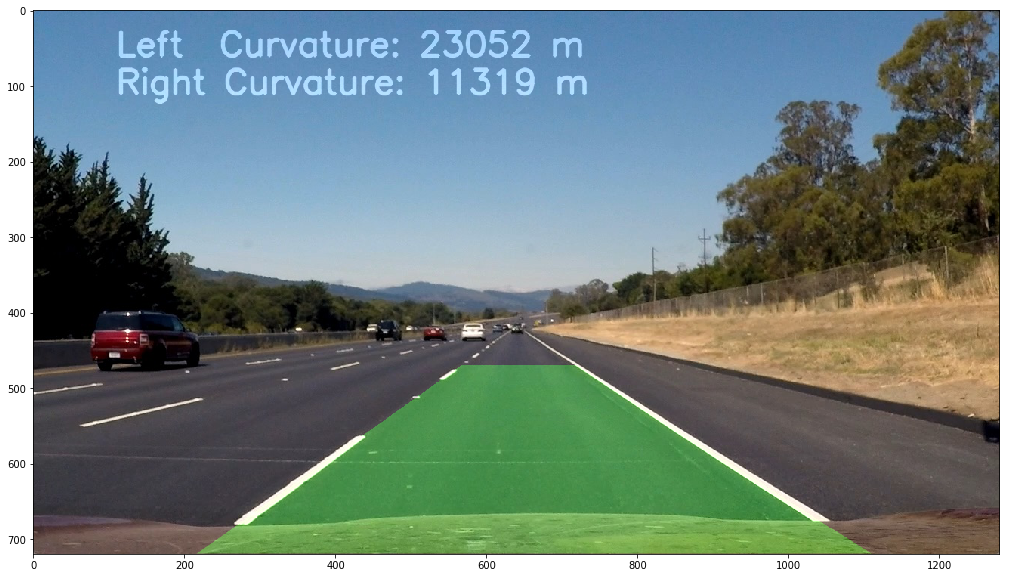

In [45]:
# Testing the draw lane functionality
marked_lane = draw_lane(img, warped, left_fit, right_fit, ploty, left_curverad, right_curverad, M_inv)

plt.figure(figsize=(20,10))
plt.imshow(marked_lane);

# Step 8: Display lane boundaries and numerical estimation of lane curvature and vehicle position.

In [46]:
def software_pipeline(img):
    
    # Binary Undistorced Warped Image
    binary_warped, M_inv = binary(img)
    
    # Fit the lines
    left_fit, right_fit,out_img, lefty, leftx, righty, rightx, ploty = fitlines(binary_warped)    
    
    # Calulating the left and right lines curvatures
    left_curverad, right_curverad = lane_curvatures(lefty, leftx, righty, rightx, ploty)
    
    # Draw Lane between road lines
    processed_lane = draw_lane(img, binary_warped, left_fit, right_fit, ploty, left_curverad, right_curverad, M_inv)

    return processed_lane


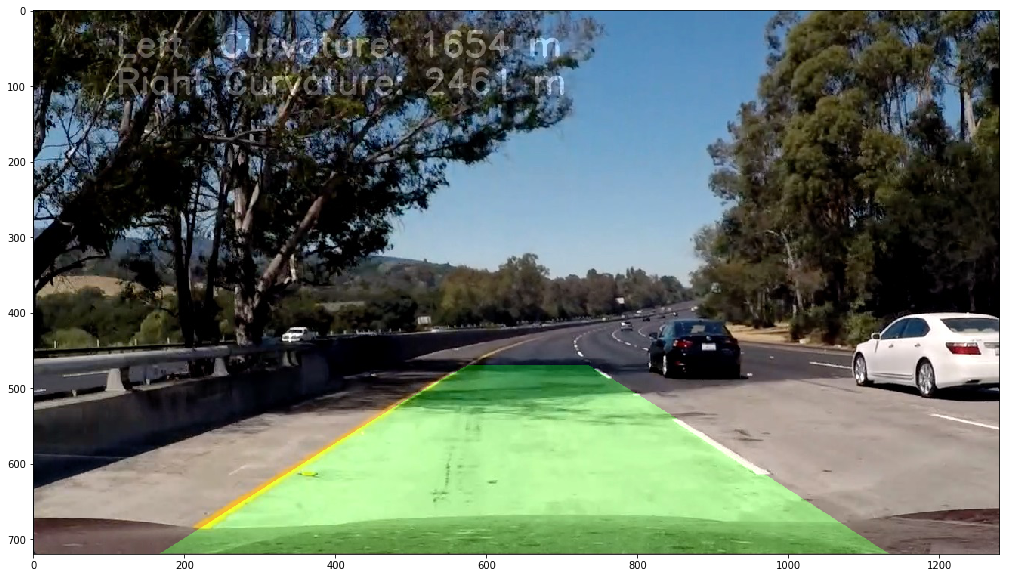

In [50]:
#Select a random image to test the sodtware pipeline
random_image = np.random.choice(len(images))

img = mpimg.imread(images[random_image])
processed_image = software_pipeline(img)
plt.figure(figsize=(25,10))
plt.imshow(processed_image);
plt.savefig('writeup_images/final_output_image.png', dpi=300, bbox_inches='tight')

# Step 9: Run pipeline in a video.

The entire software pipeline is run in a video which is a collection of multiple frames.

In [49]:
#Create video file pipeline
output = 'writeup_images/out_test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(1,2)

out_clip = clip1.fl_image(software_pipeline) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)

HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video writeup_images/out_test_video.mp4
[MoviePy] Writing video writeup_images/out_test_video.mp4


100%|█████████▉| 1260/1261 [05:40<00:00,  3.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: writeup_images/out_test_video.mp4 

CPU times: user 2min 54s, sys: 36.1 s, total: 3min 30s
Wall time: 5min 43s
